In [69]:
# v2: updated the Larch package following github, then the plot features have to be changed
# v2.1: use defination for all the process and make the program suitable for mutiple data
# v2.2: delete find_smoothest_range(data, window_size) in kmax part
# v2.3: use 1st shell reff 
# v2.4: clean version for 2.3
# v2.5: use derivative for Kmax

# Python package

In [ ]:
import larch.xafs  as lx
from larch.xafs import (pre_edge, autobk, sort_xafs, xftf, xftr, ff2chi, feffpath, feffit_transform, feffit_dataset, feffit, feffit_report, estimate_noise)
from larch.fitting import param, guess, param_group
from larch.io import read_ascii
from larch.plot.plotly_xafsplots import *
from larch.xrd import get_amcsd
from larch.xrd.structure2feff import structure2feffinp

# General imports
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
import os
import glob
import copy
import re  

# Plotly imports
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Jupyter notebook-specific imports
from ipywidgets import interact, widgets
from IPython.display import display, HTML, clear_output
from ipywidgets import VBox


%matplotlib inline
# Set the default font for the entire plot
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['font.size'] = 20           # Set default font size
mpl.rcParams['axes.labelsize'] = 20      # Axis label font size
mpl.rcParams['axes.titlesize'] = 20      # Title font size
mpl.rcParams['xtick.labelsize'] = 18     # Tick label sizes
mpl.rcParams['ytick.labelsize'] = 18
mpl.rcParams['legend.fontsize'] = 18     # Legend font size
mpl.rcParams['figure.titlesize'] = 22    # Overall figure title font size

# Basic functions

### For plot

In [71]:
def plot_traces(*figs):
    fig = go.Figure()
    for fig_i in figs:
        fig.add_traces(fig_i.traces)
    fig.show()
    
    
def quad_plots(figs_E, figs_k=None, figs_R=None, figs_q=None, title=None):
    fig = make_subplots(rows=2, cols=2, subplot_titles=("Energy", "k-space", "R-space", "q-space"), horizontal_spacing=0.1, vertical_spacing=0.1)
    fig.update_layout(height=600, width=1000,title_text=title)

    for fig_i in figs_E.traces:
        fig.add_trace(fig_i, row=1, col=1)

    if figs_k is not None:
        for fig_i in figs_k.traces:
            fig.add_trace(fig_i, row=1, col=2)
    
    if figs_R is not None:
        for fig_i in figs_R.traces:
            fig.add_trace(fig_i, row=2, col=1)
    
    if figs_q is not None:
        for fig_i in figs_q.traces:
            fig.add_trace(fig_i, row=2, col=2)

    fig.show()

### Search the smoothest data region 

In [72]:
def find_smoothest_range(data, window_size):
    """
    Finds the smoothest range in an oscillation curve based on variance.
    Parameters:
    - data: 1D array or list representing the oscillation curve.
    - window_size: Size of the window for calculating variance.

    Returns:
    - Start and end indices of the smoothest range.
    """
    window_size = int(window_size)  # Ensure window_size is an integer
    variances = np.zeros(len(data) - window_size + 1)
    for i in range(len(variances)):
        variances[i] = np.var(data[i:i+window_size])
    smoothest_index = np.argmin(variances)
    start_index = smoothest_index
    end_index = smoothest_index + window_size - 1
    return start_index, end_index

### Search the first shell peak

In [73]:
def find_peak_range(x, y, valley_threshold=0.3):
    """
    Finds the highest peak and returns the x-range that includes just that peak,
    bounded by a left valley and a right threshold crossing before the next peak.
    
    Parameters:
    x : array-like
        The x data points.
    y : array-like
        The y data points (corresponding to x).
    valley_threshold : float
        Fraction of the peak height used to define the cutoff.

    Returns:
    dict
        Dictionary with indices and x-range around the highest peak.
    """
    y = np.asarray(y)
    x = np.asarray(x)

    # Find peaks and valleys
    peaks, _ = find_peaks(y)
    valleys, _ = find_peaks(-y)

    if len(peaks) == 0:
        raise ValueError("No peaks found.")

    # Identify the highest peak
    highest_peak_idx = peaks[np.argmax(y[peaks])]
    highest_peak_x = x[highest_peak_idx]
    highest_peak_y = y[highest_peak_idx]

    # ---- Left boundary ----
    left_valleys = valleys[valleys < highest_peak_idx]
    if len(left_valleys) > 0:
        left_valley_idx = left_valleys[-1]
        left_valley_x = x[left_valley_idx]
    else:
        left_valley_idx = None
        left_valley_x = highest_peak_x - 0.6

    # ---- Right boundary ----
    # Search from peak toward right until signal falls below 30% of the peak
    right_x = None
    for i in range(highest_peak_idx + 1, len(y)):
        # Stop at the next peak (don't include second peak)
        if y[i] > y[i - 1] and y[i] > y[i + 1]:  # local peak
            break
        if y[i] < valley_threshold * highest_peak_y:
            right_x = x[i]
            break

    if right_x is None:
        right_x = highest_peak_x + 0.6  # fallback

    return {
        "peak_x_idx": highest_peak_idx,
        "peak_y": highest_peak_y,
        "left_valley_idx": left_valley_idx,
        "right_cutoff_x": right_x,
        "x_range": (left_valley_x, right_x)
    }

# Data Analysis

##  Step 1: Load data and structure

### Load data 

In [74]:
def load_data(data_path):
       data = read_ascii(data_path, labels='col1, col2')
       data.is_frozen = False
       data.datatype = 'xas'
       data.xdat = data.data[0, : ]
       data.ydat = data.data[1, : ]/1.0
       data.yerr = 1.0
       data.energy = data.xdat
       data.mu = data.ydat
       sort_xafs(data, overwrite=True, fix_repeats=True)
       data.filename = data_path.split(os.sep)[-1]
       plt.figure()
       plt.plot(data.xdat,data.ydat)
       plt.title('Loaded data')
       return data

### FEFF files

In [75]:
def generate_feff_path1(cif, element, structure_num, structure_show=True, feff_show=False):
    feff_folder = "/Users/cheny8/.larch/feff/"
    # first connect to the CIF Database
    cifdb = get_amcsd()
    # now get a list of structures.   You can use any combination of
    #cifdb.find_cifs(id=None, mineral_name=None, author_name=None, 
    #                journal_name=None, contains_elements=None, 
    #                excludes_elements=None, strict_contains=False, 
    #                full_occupancy=False, max_matches=1000)
    structures = cifdb.find_cifs(mineral_name=cif)
    structures[structure_num]
    # print out the whole text of the CIF data with
    if structure_show:
        print(structures[structure_num].ciftext)
    # to generate a Feff input from the ciftext:
    feffinp = structure2feffinp(structures[structure_num].ciftext, absorber=element, cluster_size=6.0)
    if feff_show:
        print(feffinp)
    # Create the file path
    file_path = feff_folder + "feff.inp"
    # Write content to the file
    with open(file_path, "w") as file:
        file.write(feffinp)
    lx.feff8l(file_path, verbose=feff_show)
    feff_path1 = feff_folder + "feff0001.dat"

    with open(feff_path1, 'r') as file:
        lines = file.readlines()
    # Iterate through the lines to find the line containing 'reff' value
    for line in lines:
        if line.strip().startswith('2 '):  # Assuming '2' is the path index
            parts = line.split()
            try:
                reff_index = 2  # The index of 'reff' in the line (0-based index)
                reff_value = float(parts[reff_index])
            except (IndexError, ValueError):
                print("Error: Could not parse 'reff' value.")
    return feff_path1, reff_value

## Step 2 Normalization + Background

### Data group

In [76]:
def data_nor_bg(data, figure=True):
       print(f'Data normalization:')
       
       # Normalization
       pre_edge(data, pre1=-150, pre2=-60.00, 
              nvict=0, nnorm=2, norm1=50.00, norm2=600)
       print(f'pre_edge(data, pre1=-150, pre2=-60.00, nvict=0, nnorm=2, norm1=50.00, norm2=600)')
       
       # Background function
       autobk(data, 
              rbkg=1.0, 
              ek0=data.e0,
              kmin=0.000, kmax=30, kweight=2.0,
              clamp_lo=0, clamp_hi=0)
       print(f'autobk(data, rbkg=1.0, ek0=data.e0, kmin=0.000, kmax=30, kweight=2.0, clamp_lo=0, clamp_hi=0)')
       
       if figure:
              print(f'Plot after the normalization:')
              fig1 = plot_mu(data, show_norm=False, show_deriv=False,
                            show_pre=True, show_post=True, show_e0=True, with_deriv=False,
                            emin=None, emax=None, label=f'mu_nor_bg',offset=0,title=None, fig= None, show=True)
              fig1.set_style(width=800, height=350) 
              indice = np.where(data.energy>data.ek0)[0][0]
              fig1.add_plot([data.energy[indice]], [data.mu[indice]], label='ek0', color='red',linewidth=0, marker=dict(size=5))
              fig1.show()

              fig2 = plot_chik(data, kweight=1, label=f'chik_nor_bg', kmax=None, 
                               show_window=False, scale_window=True, title=None, offset=0, show=True, fig=None)
              #fig2.set_style(width=800, height=350)
              #fig2.show()
       return data

## Step 3 Set transform from k to R, find kmax with low noise

### k_max

In [77]:
def generate_kmax_low_noise(data, noise_factor, noise_threshold, kmax_start, kmax_end, kmax_step, r_window_size=30, figure=True):
    print(f'Looking for kmax in the range of ({kmax_start:.2f},{kmax_end:.2f}):')

    # Find the smoothest range using kmax_start
    datacopy=copy.deepcopy(data)
    xftf(datacopy, kmin=3, kmax=kmax_start, dk=1.000, kweight=3.000, window='Hanning', rmax_out=30.000)
    print(f'xftf(data, kmin=3, kmax= {kmax_start}, dk= 1.000, kweight= 3.000, window=Hanning, rmax_out=30.000)')

    # k weight should be 3 to magnifize the noise part.
    start_index, end_index = find_smoothest_range(datacopy.chir_re, r_window_size)
    r_start_noise = datacopy.r[start_index]
    r_end_noise = datacopy.r[end_index] 
    print(f'find the smoothest range r={r_start_noise:.2f}~{r_end_noise:.2f}')

    if kmax_end > np.max(data.k):
        print(f"Error: kmax End should not exceed the maximum value of {np.max(data.k):.2f}. Now kmax_end = {np.max(data.k):.2f}")
        kmax_end = np.max(data.k)

    epsilon_r_list=[]
    kmax_range = np.arange(kmax_start, kmax_end, kmax_step)
    # Plot chir_re for each kmax
    plt.figure(figsize=(10,11))
    # Generate a color map
    num_steps = int((kmax_end - kmax_start) / kmax_step)+1
    colors = plt.cm.jet(np.linspace(0, 1, num_steps))
    for idx, number in enumerate(kmax_range):
        data_copy=copy.deepcopy(data)
        #estimate_noise(data_copy.k, data_copy.chi, group=data_copy, rmin=r_start_noise, rmax=r_end_noise, kweight=3, kmin=3, kmax=number, dk=1, kwindow='Hanning')#, dk2=None, kstep=0.05,  nfft=2048, _larch=None)
        estimate_noise(data_copy.k, data_copy.chi, group=data_copy, rmin=r_start_noise, rmax=r_end_noise, kweight=3, kmin=3, kmax=number, dk=1, kwindow='Hanning')#, dk2=None, kstep=0.05,  nfft=2048, _larch=None)
        epsilon_r=data_copy.epsilon_r
        epsilon_r_list.append(epsilon_r)
        
        # Check chi_re plot
        xftf(data_copy, kmin=3, kmax=number, dk= 1.000, kweight=3, window='Hanning', rmax_out=30.000) 
        # Import data to data group with indentifier with kmax values 
        indentifier="kmax="+ f"{number:.1f}"
        setattr(data_copy, indentifier, data_copy.chir_re)
        # Boolean indexing to filter "r" values within the specified range
        mask = (data_copy.r >= r_start_noise) & (data_copy.r <= r_end_noise)
        # Extract "chir_re" values corresponding to the filtered "r" range
        chir_re_for_r_range = data_copy.chir_re[mask]
        # Maximum of absolute chir_re values
        Abs_Max = np.max(np.abs(chir_re_for_r_range))

        if figure:
            plt.subplot(2, 1, 1)
            plt.plot(data_copy.r, data_copy.chir_re, label=indentifier, color=colors[idx])
            plt.axvspan(r_start_noise, r_end_noise, color='yellow', alpha=0.1)
            plt.xlabel('$R$ (Å)') 
            plt.xlim(0,np.max(data_copy.r))  
            plt.ylabel('Re[$\chi(R)$] ($Å^{-3}$)')
            plt.legend(loc='upper left', frameon=False, bbox_to_anchor=(1, 1))

            plt.subplot(2, 1, 2)
            plt.plot(data_copy.r, data_copy.chir_re, label=indentifier, color=colors[idx])
            plt.xlim(r_start_noise, r_end_noise) 
            plt.ylim(-Abs_Max, Abs_Max)  
            plt.xlabel('$R$ $(Å)$') 
            plt.ylabel('Re[$\chi(R)$] ($Å^{-3}$)')
    
    gradient1st=np.gradient(epsilon_r_list, kmax_range)
    gradient2nd=np.gradient( gradient1st, kmax_range)

    if figure:
        fig, ax1 = plt.subplots()
        ax1.plot(kmax_range, epsilon_r_list, 'o-', label="$\epsilon_r$")
        ax1.axhline(y=noise_threshold, color='orange', linestyle=':', linewidth=2)
        ax1.set_xlabel('$k_{max}$ ($Å^{-1}$)')
        ax1.set_ylabel('$\epsilon_r$')
        ax1.set_xlim(8,16)
        # ax1.set_ylim(0,1.5)
        #ax1.set_ylim(min(gradient2nd)-((max(epsilon_r_list)-min(epsilon_r_list))*0.1),max(epsilon_r_list)+((max(epsilon_r_list)-min(epsilon_r_list))*0.1))
        #ax2 = ax1.twinx() 
        #ax2.plot(kmax_range, gradient1st, 's-', label="1st", color='#ff7f0e')
        #ax2.plot(kmax_range, gradient2nd, '^-', label="2nd", color='#2ca02c')
        #ax2.set_ylabel("Derivative")
        #ax2.set_ylim(min(gradient2nd)-((max(epsilon_r_list)-min(epsilon_r_list))*0.1),max(epsilon_r_list)+((max(epsilon_r_list)-min(epsilon_r_list))*0.1))
        #ax2.legend(loc='upper left', frameon=False)
        fig.tight_layout() 

    noise = list(zip(kmax_range, epsilon_r_list))
    grad1st = list(zip(kmax_range, gradient1st))
    grad2nd = list(zip(kmax_range, gradient2nd))

    df_noise=pd.DataFrame(noise)
    df_grad1st=pd.DataFrame(grad1st)
    df_grad2nd=pd.DataFrame(grad2nd)
    df_noise.to_csv(f'epsilon_r.csv', mode='a', index=False) 
    df_grad1st.to_csv(f'epsilon_r_1st_derivative.csv', mode='a', index=False) 
    df_grad2nd.to_csv(f'epsilon_r_2nd_derivative.csv', mode='a', index=False)
    print(f'Estimate_noise (kmax, epsilon_r):')
    print(df_noise.to_string(index=False))

    if len(noise)==1:
        kmax_low_noise = noise[0][0]
    else:
        # Iterate through the noise data
        for i in range(1, len(noise)):
            current_value = noise[i][1]
            first_value = noise[0][1]
            #current_value = grad2nd[i][1]
            #first_value = grad2nd[0][1]
        # Noise evaluation: noise_factor is usually set as 2; 
        # noise_threshold is usually set 0.35 at k-weight=3, which is epsilon_r vaulue. Shelly Kelly found this value after comparing good and bad data.  
            if current_value > noise_threshold: #current_value > noise_factor * first_value and 
                kmax_low_noise = noise[i - 1][0]
                break
            else:
                kmax_low_noise = noise[-1][0]
    print(f'current_value > {noise_threshold}') 
    display(HTML(f"<strong style='color: red; font-size: 16px;'>The kmax for low noise is: {kmax_low_noise}</strong>"))
    return kmax_low_noise


## Step 4 Fit the 1st shell to find kmin
Using a Path file from FEFF calculation. Here we give math expressions using the Parameters named in the Parameter group to set the values for the Path Parameters in the EXAFS equation.
We will vary amplitude, e0, sigma2, and delta_R, and a third cumulant C3.

### Fit the 1st shell to get the theory results

In [78]:
def first_shell_theory(data, kmax_low_noise, feff_path1_file, reff, figure=True):
    print(f'Fit the 1st shell to get the theory:')
    #print(f'reff={reff:.2f}')

    xftf(data, kmin=3, kmax=kmax_low_noise, dk=1.000, kweight=1.000, window='Hanning', rmax_out=12.000)
    print(f'xftf(data, kmin=3, kmax={kmax_low_noise}, dk=1.000, kweight=1.000, window=Hanning, rmax_out=12.000)')

    datacopy=copy.deepcopy(data)
    xftf(datacopy, kmin=3, kmax=8, dk=1.000, kweight=3.000, window='Hanning', rmax_out=30.000)
    peak_info = find_peak_range(datacopy.r, datacopy.chir_mag)
    rmin=peak_info['x_range'][0]
    rmax=peak_info['x_range'][1]

    if figure:
        print(f'plot_chir(data, label=chir_nor_bg, show_window=True)')
        plot_chir(data, label=f'chir_nor_bg', show_window=True)

    path1 = feffpath(feff_path1_file, s02='amp', e0='de0', c3='c3', sigma2='sig2', deltar='delr')
    pars0 = param_group(amp=param(0.99, vary=True, min=0.7, max=1),
                        de0=param(0, vary=True),
                        c3=param(0, vary=False),
                        sig2=param(0.010, vary=True),
                        delr=param(-0.01, vary=True))
    print(f'param_group(amp=param(0.99, vary=True, min=0.7, max=1), de0=param(0, vary=True), c3=param(0, vary=False), sig2=param(0.010, vary=True), delr=param(-0.01, vary=True))')

    # get r range base on the first chr peak.
    #trans0 = feffit_transform(kmin=3, kmax=kmax_low_noise, kweight=[1], dk=1, window='Hanning', rmin=reff-1.3, rmax=reff+0.7)
    trans0 = feffit_transform(kmin=3, kmax=kmax_low_noise, kweight=[1], dk=1, window='Hanning', rmin=rmin, rmax=rmax)
    print(f'feffit_transform(kmin=3, kmax={kmax_low_noise}, kweight=[1], dk=1, window=Hanning, rmin={rmin}, rmax={rmax})')
    dset0 = feffit_dataset(data=data, pathlist=[path1], transform=trans0)
    result0 = feffit(pars0, dset0)
    # print out the fit report
    output0 = feffit_report(result0, with_paths=True)

    print('output0 in the process of first_shell_theory:')
    print(output0)
    # find delE0 in the fit result
    de0 = result0.params["de0"].value
    if figure:
        print(f'Theoretical chi(k) with de0={de0:.2f}, autobk without theory:')
        plot_chifit(result0.datasets[0], kweight=1, show_real=False)

        plt.figure()
        plt.plot(data.k, data.k*data.chi, label='Data', color='b')
        plt.plot(dset0.model.k, dset0.model.k*dset0.model.chi, label='Theory', color='r')
        plt.xlabel('$k$ $(Å^{-1})$')
        plt.ylabel('$k\chi(k)$ $(Å^{-1})$')
        plt.title(f'Theoretical chi(k) with de0={de0:.2f}, autobk without theory')
        plt.legend(frameon=False)
        plt.show()
        #print(f'Theoretical chi(R) with de0={de0:.2f}:')
        #plot_path_r(result0.datasets[0], 0, rmax=None, offset=0, label=None, title=None, show_mag=True, show_real=False, show_imag=True)
        #plot_paths_r(result0.datasets, offset=-0.5, rmax=None, show_mag=True, show_real=False, show_imag=False, win=1)

    # Use the fit results above except set delE=0 to find model's k and chi, build a theory for data with delE=0
    pars1 = param_group(amp=param(result0.params["amp"].value, vary=False),
                        de0=param(0, vary=False),
                        c3=param(result0.params["c3"].value, vary=False),
                        sig2=param(result0.params["sig2"].value,vary=False),
                        delr=param(result0.params["delr"].value),vary=False)
    print(f'param_group(amp=param(result0.params["amp"].value, vary=False), de0=param(0, vary=False), c3=param(result0.params["c3"].value, vary=False), sig2=param(result0.params["sig2"].value,vary=False), delr=param(result0.params["delr"].value),vary=False)')
    #trans1 = feffit_transform(kmin=3, kmax=kmax_low_noise, kweight=[1], dk=1, window='Hanning', rmin=reff-1.3, rmax=reff+0.7)
    trans1 = feffit_transform(kmin=3, kmax=kmax_low_noise, kweight=[1], dk=1, window='Hanning', rmin=rmin, rmax=rmax)
    print(f'feffit_transform(kmin=3, kmax={kmax_low_noise}, kweight=[1], dk=1, window=Hanning, rmin={rmin}, rmax={rmax})')
    dset1 = feffit_dataset(data, pathlist=[path1], transform=trans1)
    result1 = feffit(pars1, dset1)
    output1 = feffit_report(result1, with_paths=True)
    if figure:
        print(f'Theoretical chi(k) with de0=0, autobk without theory:')
        plot_chifit(result1.datasets[0], kweight=1, show_real=False)
       
        plt.figure()
        plt.plot(data.k, data.k*data.chi, label='Data', color='b')
        plt.plot(dset1.model.k, dset1.model.k*dset1.model.chi, label='Theory', color='r')
        plt.xlabel('$k$ $(Å^{-1})$')
        plt.ylabel('$k\chi(k)$ $(Å^{-1})$')
        plt.title(f'Theoretical chi(k) with de0=0, autobk without theory')
        plt.legend(frameon=False)
        plt.show()
    return  de0, dset1.model.k, dset1.model.chi



### Substract background using the model's k and chi 

In [79]:
def data_nor_bg_theory(data, kmax_low_noise, de0, k_theory, chi_theory, reff, figure=True):
    # Find rbkg value
    rbkg_val = reff-1
    if rbkg_val > 1.4:
        rbkg_val = 1.4
    #print(f'rbkg={rbkg_val:.1f} (reff-1 or 1)')
    print(f'rbkg=1')
    # Normalization
    pre_edge(data, pre1=-150, pre2=-60.00, 
            nvict=0, nnorm=2, norm1=150.00, norm2=600)
    print(f'pre_edge(data, pre1=-150, pre2=-60.00, nvict=0, nnorm=2, norm1=50.00, norm2=600)')

    # Substract background using the model's k and chi
    autobk(data, 
        rbkg= 1,#rbkg_val,
        ek0= data.e0+de0,
        kmin= 0.000, kmax= kmax_low_noise, kweight= 2.0,
        clamp_lo= 0, clamp_hi= 0, k_std=k_theory, chi_std=chi_theory)
    print(f'autobk(data, rbkg={rbkg_val:.2f}, ek0={data.e0+de0:.2f}, kmin=0.000, kmax={kmax_low_noise}, kweight=2.0, clamp_lo= 0, clamp_hi= 0, k_std=k_theory, chi_std=chi_theory')
    
    if figure:
        print(f'Plot after e0 shift based on the theory:')
        xftf(data, kmin= 3, kmax= kmax_low_noise, dk= 1.000, kweight= 1.000, window='Hanning', rmax_out=12.000)
        #xftr(data, rmin= 1.000, rmax= 6.000, dr= 0.500, window='Hanning')
        fig1 = plot_mu(data, show_norm=False, show_flat=False,
                    show_e0=True, show_pre=True, show_post=True,
                    label='mu after bkg removed with_e0_shift',offset=0,title=None,
                    show_deriv=False, with_deriv=False)
        fig1.set_style(width=800, height=350) 
        indice = np.where(data.energy>data.ek0)[0][0]
        fig1.add_plot([data.energy[indice]], [data.mu[indice]], label='ek0', color='red',linewidth=0, marker=dict(size=5))
        fig1.show()

        fig2 = plot_chik(data, kweight=1, label=f'chik after bkg removed with_e0_shift', kmax=None, 
                               show_window=False, scale_window=True, title=None, offset=0, show=True, fig=None)
        
        #fig2.set_style(width=800, height=350)
        #fig2.show()
        
        #print(f'plot theory and data with e0 shift, autobk with k_std using theory:')
        print(f'plot theory and data without e0 shift, autobk with k_std using theory:')
        plt.figure()
        plt.plot(k_theory, k_theory*chi_theory, 'r-', label=f'theory')
        plt.plot(data.k, data.k*data.chi, 'b-', label=f'data')
        plt.xlabel('$k$ $(Å^{-1})$')
        plt.ylabel('$k\chi(k)$ $(Å^{-1})$')
        plt.legend(frameon=False)
        #plt.title('Theory and data with e0 shift, autobk with k_std using theory')
        plt.title('Theory and data without e0 shift, autobk with k_std using theory')

        #plot_bkg(data, label=f'bkg_nor_bg_theory')



### k_min

In [80]:
def generate_kmin_small_r_factor(data, kmax_low_noise, feff_path1_file, kmin_start=2, kmin_end=4, kmin_step=0.5, reff=2, fit_report=True, figure=True):
    print(f'Looking for kmin:')
    pars_fix = param_group(amp=param(0.99, vary=True, min=0.7, max=1),
                   de0=param(0, vary=True),
                   c3=param(0, vary=False),
                   sig2=param(0.010, vary=True),
                   delr=param(-0.01, vary=True))
    print(f'param_group(amp=param(0.99, vary=True, min=0.7, max=1), de0=param(0, vary=True), c3=param(0, vary=False), sig2=param(0.010, vary=True), delr=param(-0.01, vary=True))')
    
    path1 = feffpath(feff_path1_file, s02='amp', e0='de0', c3='c3', sigma2='sig2', deltar='delr')
    
    datacopy=copy.deepcopy(data)
    xftf(datacopy, kmin=3, kmax=8, dk=1.000, kweight=3.000, window='Hanning', rmax_out=30.000)
    peak_info = find_peak_range(datacopy.r, datacopy.chir_mag)
    rmin=peak_info['x_range'][0]
    rmax=peak_info['x_range'][1]
    
    r_factors=[] 
    # For each kmin, fit the first shell to find r_factor
    for num in np.arange(kmin_start, kmin_end, kmin_step):
        data=copy.deepcopy(data)
        data.energy=data.energy
        xftf(data, kmin=num, kmax=kmax_low_noise, dk= 2.000, kweight= 1.000, window='Hanning', rmax_out=12.000)

        # Import data to data group with indentifier with kmin values 
        indentifier= "kmin" + f"{num:.1f}"
        setattr(data, indentifier, data.chir_mag)

        trans = feffit_transform(kmin=num, kmax=kmax_low_noise , kweight=[1], dk=2, window='Hanning', rmin=rmin, rmax=rmax)
        #print(f'Fit range: [{0.5:.1f},{reff:.1f}] ([0.5,reff])')
        print(f'Fit r range:[{rmin,rmax}]')
        dset = feffit_dataset(data=data, pathlist=[path1], transform=trans)
        result = feffit(pars_fix, dset)
        r_factor = result.rfactor
        r_factors.append(r_factor)
        if fit_report:
            output=feffit_report(result, with_paths=True)
            print(output)
        if figure:
            print(f'kmin={num}')
            plot_chifit(dset, kmin=0, kmax=None, kweight=None, rmax=None,
                        show_mag=True, show_real=False, show_imag=False,
                        show_bkg=False, use_rebkg=False, title=None, offset=0)
            
            print("*******")
            print(dir(dset))
            print(dir(dset.data))
            print(dir(dset.model))
            print("*******")
            plt.figure(figsize=(6, 4))
            # Plot raw and fit real parts of chi(R)
            plt.plot(dset.data.r, dset.data.chir_mag, label='data', color='blue', linewidth=2)
            plt.plot(dset.model.r, dset.model.chir_mag, label='fit', color='red', linestyle='--',linewidth=2)
            plt.plot(dset.model.r, dset.data.chir_mag - dset.model.chir_mag, label='residual', color='gray', linestyle='-.',linewidth=2)
            # Vertical lines at R = 1 Å and 2 Å
            plt.axvline(x=rmin, color='orange', linestyle=':', linewidth=2)
            plt.axvline(x=rmax, color='orange', linestyle=':', linewidth=2)
            # Axis labels and title
            plt.xlabel('$R$ $(Å)$')
            plt.ylabel('$|\chi(R)]|$ $(Å^{-1})$')
            plt.xlim(0,6)
            # plt.title('Real Part of χ(R): Raw vs. Fit')
            # Show legend without box
            plt.legend(frameon=False)
            # Turn on all four spines
            for spine in plt.gca().spines.values():
                spine.set_visible(True)
            # Grid and layout
            plt.grid(False)
            plt.tight_layout()
            plt.show()  
            print("*******") 
            

    if figure:
        plt.figure()
        plt.plot(np.arange(kmin_start, kmin_end, kmin_step), r_factors, 'o-')
        plt.xlabel('$k_{min}$ $(Å^{-1})$')
        plt.ylabel('R-factor')    
    
    r_factor_list = list(zip(np.arange(kmin_start, kmin_end, kmin_step), r_factors))
    # Create a list of tuples containing kmin values and r_factors
    r_factor_list = list(zip(np.arange(kmin_start, kmin_end, kmin_step), r_factors))
    # Find the tuple with the smallest r_factors
    min_r_factor_tuple = min(r_factor_list, key=lambda x: x[1])
    # Extract the kmin value from the tuple
    kmin_small_r_factor = min_r_factor_tuple[0]

    display(HTML(f"<strong style='color: red; font-size: 16px;'>The kmin for small R-factor is: {kmin_small_r_factor}</strong>"))

    return kmin_small_r_factor

## Step 5 Use the k range

### INPUT

In [81]:
folder = "/Users/cheny8/_0SPC/Larch_k_range/test/"

# [dat file name, mineral name, element]
# In data file, column[0]=energy, column[1]=mu
data_list=[
           ["Cufoil_merge.dat", "Copper", "Cu"],
    #        ["Cu2O_merge.dat", "Cuprite", "Cu"],
    #        ["CuO_merge.dat", "Tenorite", "Cu"],
    #        ["Pt_0p5_ML.dat", "Platinum", "Pt"],
    #    #            #   ["Pt_0p5_ML_raw.txt", "Platinum", "Pt"],
    #    #            #   ["Pt_0p5_ML_cal.txt", "Platinum", "Pt"],
    #    #            #   ["Pt_0p5_ML_cal_norm.txt", "Platinum", "Pt"],
    #    #            #   ["Pt_foil_raw.txt", "Platinum", "Pt"],
    #    #            #   ["Pt_foil_cal.txt", "Platinum", "Pt"],
    #    #            #   ["Pt_foil_cal_norm.txt", "Platinum", "Pt"],
    #        ["CoNi_1_1_Fresh_Ni-edge.dat", "Nickel", "Ni"],
    #        ["CoNi_1_1_Reduced_Ni-edge.dat", "Nickel", "Ni"],
    #        ["MT-TiO2.dat", "Rutile", "Ti"],
    #        ["Clean-TiO2.dat", "Rutile", "Ti"],
           ]

### OUTPUT

/Users/cheny8/_0SPC/Larch_k_range/test/Cufoil_merge.dat
Spectrum display after "pre_edge":


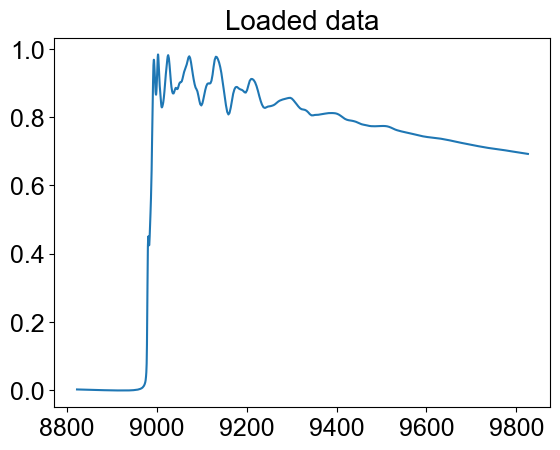

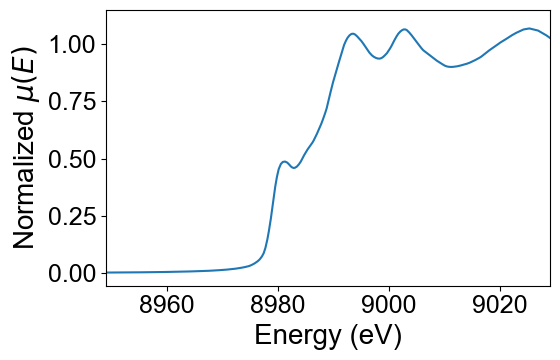

Data normalization:
pre_edge(data, pre1=-150, pre2=-60.00, nvict=0, nnorm=2, norm1=50.00, norm2=600)
autobk(data, rbkg=1.0, ek0=data.e0, kmin=0.000, kmax=30, kweight=2.0, clamp_lo=0, clamp_hi=0)
Plot after the normalization:


Looking for kmax in the range of (8.00,14.90):
xftf(data, kmin=3, kmax= 8, dk= 1.000, kweight= 3.000, window=Hanning, rmax_out=30.000)
find the smoothest range r=22.89~23.78
Estimate_noise (kmax, epsilon_r):
   0        1
 8.0 0.004033
 8.5 0.004116
 9.0 0.002555
 9.5 0.004972
10.0 0.006427
10.5 0.007797
11.0 0.009958
11.5 0.010977
12.0 0.012037
12.5 0.012968
13.0 0.013819
13.5 0.015155
14.0 0.017024
14.5 0.019578
current_value > 0.16


/Users/cheny8/anaconda3/envs/larch/lib/python3.12/site-packages/larch/xrd/structure2feff.py:156: DeprecationWarning:

dict interface is deprecated. Use attribute interface instead



Fit the 1st shell to get the theory:
xftf(data, kmin=3, kmax=14.5, dk=1.000, kweight=1.000, window=Hanning, rmax_out=12.000)
plot_chir(data, label=chir_nor_bg, show_window=True)


param_group(amp=param(0.99, vary=True, min=0.7, max=1), de0=param(0, vary=True), c3=param(0, vary=False), sig2=param(0.010, vary=True), delr=param(-0.01, vary=True))
feffit_transform(kmin=3, kmax=14.5, kweight=[1], dk=1, window=Hanning, rmin=1.1658253987930873, rmax=3.067961575771282)
output0 in the process of first_shell_theory:
=================== FEFFIT RESULTS ====================
[[Statistics]]
  n_function_calls     = 30
  n_variables          = 4
  n_data_points        = 124
  n_independent        = 14.9257812
  chi_square           = 4751.71968
  reduced chi_square   = 434.908916
  r-factor             = 0.00647459
  Akaike info crit     = 94.0198426
  Bayesian info crit   = 96.8322026
 
[[Parameters]]
  amp                  =  0.9111125 +/- 0.0531976  (init= 0.9900000)
  c3                   =  0.0000000 (fixed)
  de0                  =  4.7698270 +/- 0.5479626  (init= 0.0000000)
  delr                 = -0.0406844 +/- 0.0040954  (init=-0.0100000)
  sig2                 =  0.0

<Figure size 1000x1100 with 0 Axes>

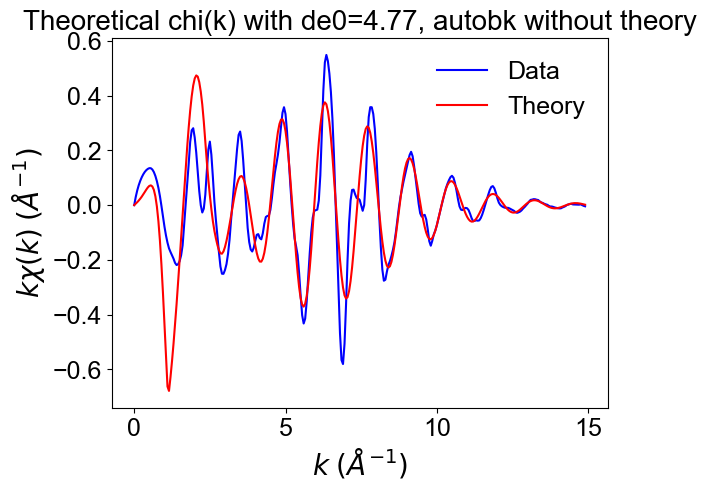

param_group(amp=param(result0.params["amp"].value, vary=False), de0=param(0, vary=False), c3=param(result0.params["c3"].value, vary=False), sig2=param(result0.params["sig2"].value,vary=False), delr=param(result0.params["delr"].value),vary=False)
feffit_transform(kmin=3, kmax=14.5, kweight=[1], dk=1, window=Hanning, rmin=1.1658253987930873, rmax=3.067961575771282)
Theoretical chi(k) with de0=0, autobk without theory:


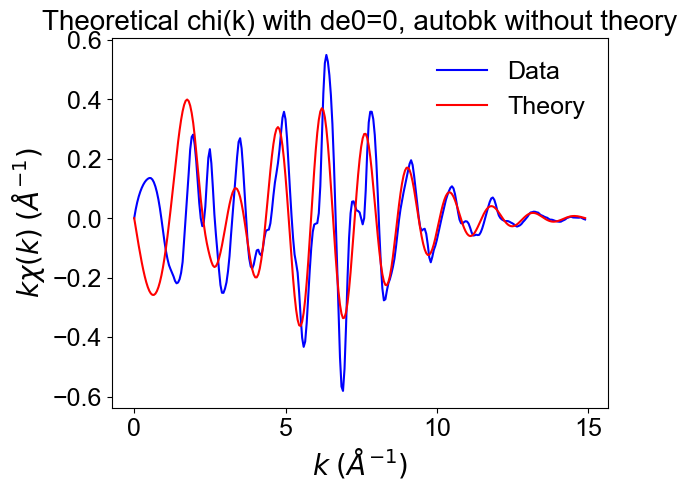

rbkg=1
pre_edge(data, pre1=-150, pre2=-60.00, nvict=0, nnorm=2, norm1=50.00, norm2=600)
autobk(data, rbkg=1.40, ek0=8983.83, kmin=0.000, kmax=14.5, kweight=2.0, clamp_lo= 0, clamp_hi= 0, k_std=k_theory, chi_std=chi_theory
Plot after e0 shift based on the theory:


plot theory and data without e0 shift, autobk with k_std using theory:
Looking for kmin:
param_group(amp=param(0.99, vary=True, min=0.7, max=1), de0=param(0, vary=True), c3=param(0, vary=False), sig2=param(0.010, vary=True), delr=param(-0.01, vary=True))
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513), np.float64(2.9759227284981438))]
Fit r range:[(np.float64(1.227184630308513)

Final fit:
kmin= 3.8000000000000016, kmax= 14.5, dk= 1.000, kweight= 2.000, window=Hanning, rmax_out=10.000


=================== FEFFIT RESULTS ====================
[[Statistics]]
  n_function_calls     = 26
  n_variables          = 4
  n_data_points        = 288
  n_independent        = 11.0312500
  chi_square           = 12.3318864
  reduced chi_square   = 1.75386829
  r-factor             = 5.0569e-04
  Akaike info crit     = 9.22950059
  Bayesian info crit   = 10.8324292
 
[[Parameters]]
  amp                  =  0.8314268 +/- 0.0175522  (init= 0.9900000)
  c3                   =  0.0000000 (fixed)
  de0                  =  0.4117548 +/- 0.2482371  (init= 0.0000000)
  delr                 = -0.0389961 +/- 0.0015798  (init=-0.0100000)
  sig2                 =  0.0085810 +/- 1.8465e-4  (init= 0.0100000)
 
[[Correlations]] (unreported correlations are <  0.100)
  de0, delr            =  0.919
  amp, sig2            =  0.914
  amp, delr            =  0.263
  delr, sig2           =  0.237
  amp, de0             =  0.152
  de0, sig2            =  0.124
 
[[Dataset]]
  unique_id            = 'd6

*******
*******


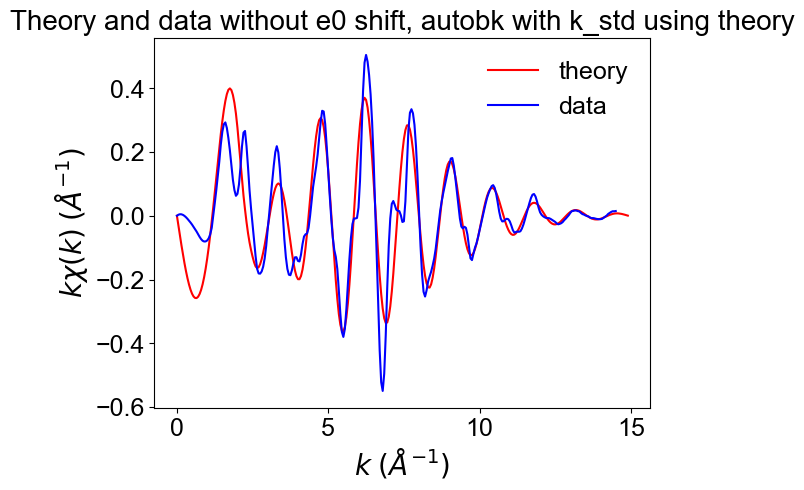

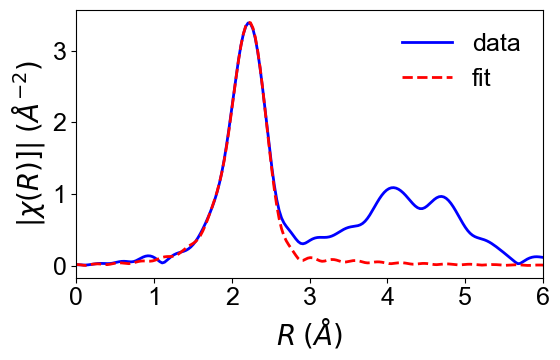

*******
*******
rbkg=1
pre_edge(data, pre1=-150, pre2=-60.00, nvict=0, nnorm=2, norm1=50.00, norm2=600)
autobk(data, rbkg=1.40, ek0=8983.83, kmin=0.000, kmax=16, kweight=2.0, clamp_lo= 0, clamp_hi= 0, k_std=k_theory, chi_std=chi_theory


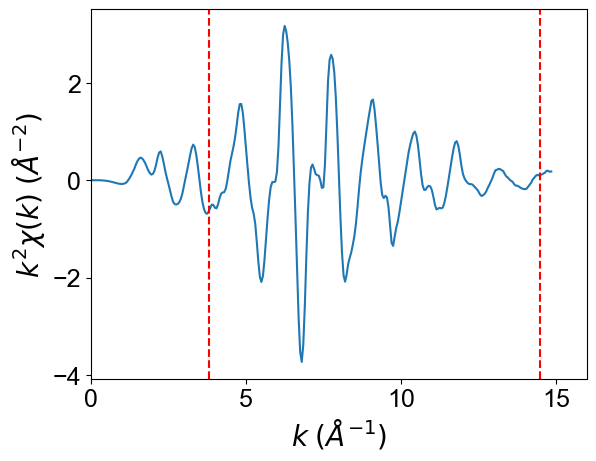

In [82]:
for n in range(len(data_list)):
    data_path = folder+data_list[n][0]
    print(data_path)
    data = load_data(data_path)
    
    pre_edge(data, pre1=-150, pre2=-60.00, 
            nvict=0, nnorm=2, norm1=50.00, norm2=600)
    print(f'Spectrum display after "pre_edge":')
    plt.figure(figsize=(6, 4))
    plt.plot(data.energy, data.flat)
    plt.xlabel('Energy (eV)')
    plt.ylabel('Normalized $\mu(E)$')
    # plt.xlim(data.e0-30, data.e0+50)
    plt.xlim(8949.062558, 9029.062558)
    print
    plt.tight_layout()
    plt.show()
    
    data1=copy.deepcopy(data)
    data_nor_bg(data1, figure=True)
    kmax_low_noise = generate_kmax_low_noise(data1, noise_factor=10, noise_threshold=0.16, 
                                             kmax_start=8, kmax_end=np.max(data1.k), 
                                             kmax_step=0.5, figure=False)
    # cif structure --> the 4th in the Mineral database list
    feff_path1_file, reff = generate_feff_path1(cif=data_list[n][1], element=data_list[n][2], 
                                             structure_num=3, structure_show=False, feff_show=False)

    de0, k_theory, chi_theory = first_shell_theory(data1, kmax_low_noise, feff_path1_file, reff, figure=True)
    data2=copy.deepcopy(data)
    data_nor_bg_theory(data2, kmax_low_noise, de0, k_theory, chi_theory, reff, figure=True)
    kmin_small_r_factor = generate_kmin_small_r_factor(data2, kmax_low_noise, feff_path1_file, 
                                                       kmin_start=2, kmin_end=4.0, kmin_step=0.2, reff=reff, fit_report=False, figure=False)

    print(f'Final fit:')
    # use data2, which already includes an energy shift in data_nor_bg_theory
    xftf(data2, kmin=kmin_small_r_factor, kmax= kmax_low_noise, dk= 1.000, kweight= 2.000, window='Hanning', rmax_out=10.000)
    print(f'kmin= {kmin_small_r_factor}, kmax= {kmax_low_noise}, dk= 1.000, kweight= 2.000, window=Hanning, rmax_out=10.000')
    xftr(data2, rmin= 1.000, rmax= 6.000, dr= 0.200, window='Hanning')

    figs_data = {}
    figs_data['mu'] = plot_mu(data2, show_norm=False, show_flat=False, 
                               show_e0=True, show_pre=True, show_post=True,
                               label=f'mu_nor_bg_theorty')
    figs_data['chik'] = plot_chik(data2, kweight=2, label=f'chik_nor_bg_theorty', kmax=None, 
                                   show_window=True, scale_window=True, title=None, offset=0, show=True, fig=None)
    figs_data['chir'] = plot_chir(data2, label=f'chir_nor_bg_theorty', show_mag=True, show_window=True)
    figs_data['chiq'] = plot_chiq(data2, label=f'chiq_nor_bg_theorty', show_chik=True, show_window=True)
    quad_plots(figs_E=figs_data['mu'], 
             figs_k=figs_data['chik'],
             figs_R=figs_data['chir'],
             figs_q=figs_data['chiq'])

    peak_info = find_peak_range(data2.r, data2.chir_mag)
    rmin=peak_info['x_range'][0]
    rmax=peak_info['x_range'][1]
    
    pars = param_group(
        # s02   = param(0.90, vary=True, min=0.7, max=1.0),
        # degen = param(1.0, vary=True, min=0.1, max=2),
        # amp   = param(expr='s02 * degen'), 
        amp=param(0.99, vary=True, min=0.7, max=1),
        de0=param(0, vary=True),
        delr=param(-0.01, vary=True),
        sig2=param(0.010, vary=True),
        c3=param(0, vary=False))
    path1 = feffpath(
        feff_path1_file, 
        s02='amp', 
        e0='de0',  
        sigma2='sig2', 
        deltar='delr',
        c3='c3',
        )

    trans = feffit_transform(kmin=kmin_small_r_factor, kmax=kmax_low_noise , kweight=[2,1,3], dk=1, window='Hanning', rmin=rmin, rmax=rmax)
    dset = feffit_dataset(data=data2, pathlist=[path1], transform=trans)
    result = feffit(pars, dset)
    output=feffit_report(result, with_paths=True)
    print(output)
    plot_chifit(dset, kmin=0, kmax=None, kweight=None, rmax=None,
                show_mag=True, show_real=False, show_imag=False,
                show_bkg=False, use_rebkg=False, title=None, offset=0)
    
    print("*******")
    print("*******")
    plt.figure(figsize=(6, 4))
    # Plot raw and fit real parts of chi(R)
    plt.plot(dset.data.r, dset.data.chir_mag, label='data', color='blue', linewidth=2)
    plt.plot(dset.model.r, dset.model.chir_mag, label='fit', color='red', linestyle='--',linewidth=2)
    # Axis labels and title
    plt.xlabel('$R$ $(Å)$')
    plt.ylabel('$|\chi(R)]|$ $(Å^{-2})$')
    plt.xlim(0,6)
    # plt.title('Real Part of χ(R): Raw vs. Fit')
    # Show legend without box
    plt.legend(frameon=False)
    # Turn on all four spines
    for spine in plt.gca().spines.values():
        spine.set_visible(True)
    # Grid and layout
    # plt.grid(True)
    plt.tight_layout()
    plt.show()  
    print("*******")
    print("*******") 
    
    #plt.figure()
    #plt.plot(data1.k, (data1.k)**2*data1.chi)
    #plt.axvline(x=kmax_low_noise, color='r', linestyle='--')
    #plt.axvline(x=kmin_small_r_factor, color='r', linestyle='--')
    #plt.xlim(0,16)
    #plt.xlabel('$k$ ($Å^{-1}$)')
    #plt.ylabel('$k^2\chi(R)$] ($Å^{-2}$)')

    # plt.figure()
    # plt.plot(data2.k, (data2.k)**2*data2.chi)
    # plt.axvline(x=kmax_low_noise, color='r', linestyle='--')
    # plt.axvline(x=kmin_small_r_factor, color='r', linestyle='--')
    # plt.xlim(0,16)
    # plt.xlabel('$k$ ($Å^{-1}$)')
    # plt.ylabel('$k^2\chi(R)$] ($Å^{-2}$)')



    data3=copy.deepcopy(data)
    data_nor_bg_theory(data3, 16, de0, k_theory, chi_theory, reff, figure=False)
    xftf(data3, kmin= kmin_small_r_factor, kmax= kmax_low_noise, dk= 1.000, kweight= 2.000, window='Hanning', rmax_out=15.000)
    
    plt.figure()
    plt.plot(data3.k, (data3.k)**2*data3.chi)
    plt.axvline(x=kmax_low_noise, color='r', linestyle='--')
    plt.axvline(x=kmin_small_r_factor, color='r', linestyle='--')
    plt.xlim(0,16)
    plt.xlabel('$k$ $(Å^{-1})$')
    plt.ylabel('$k^2\chi(k)$ $(Å^{-2})$')

## GUI

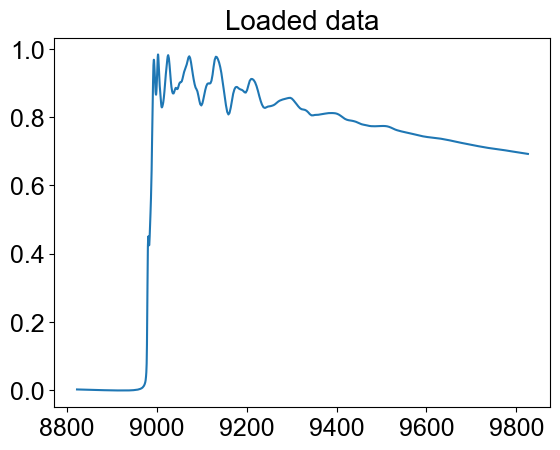

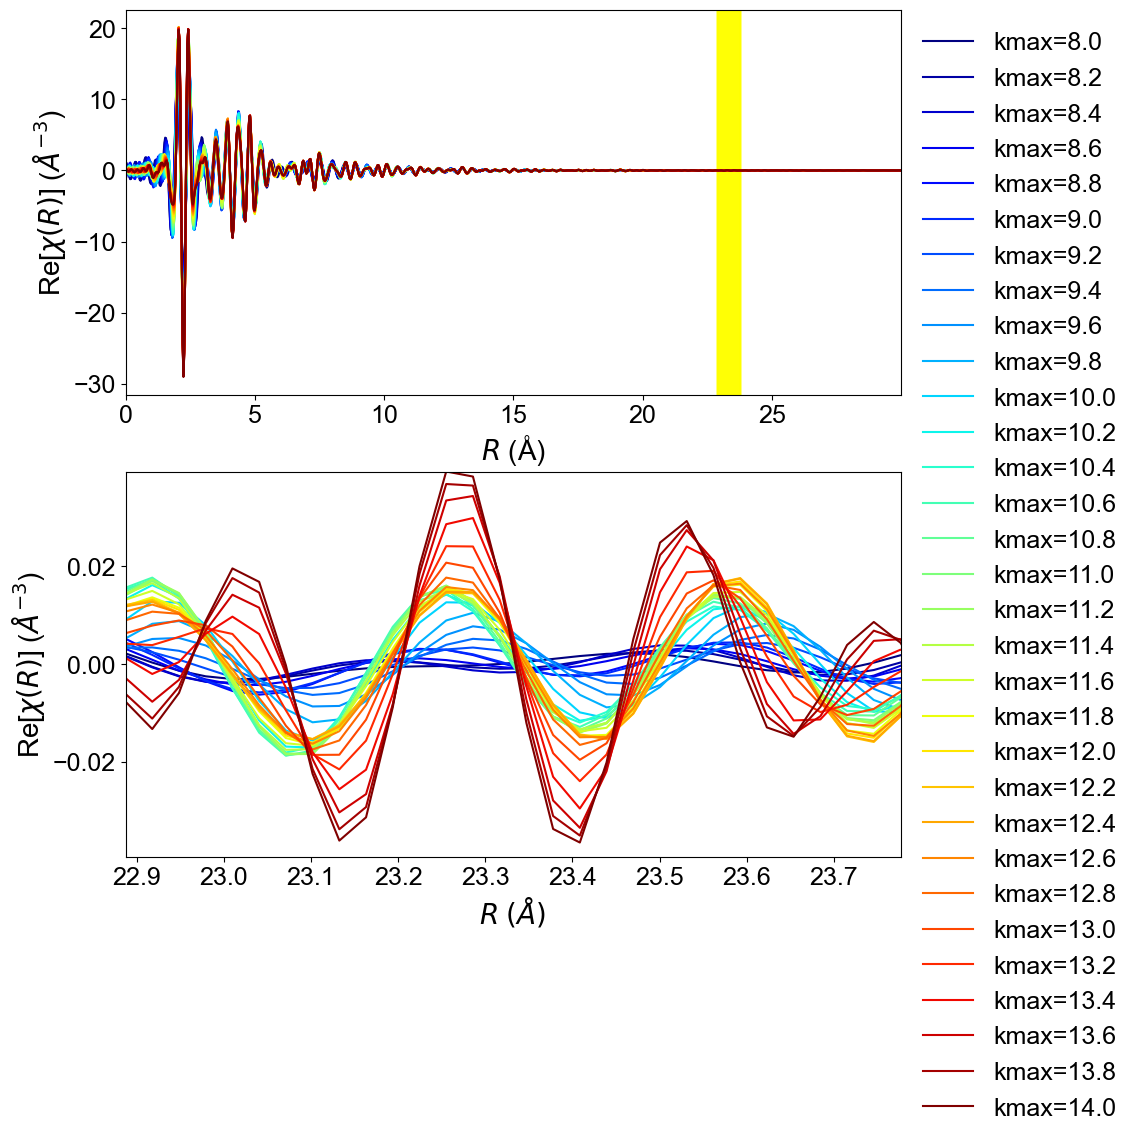

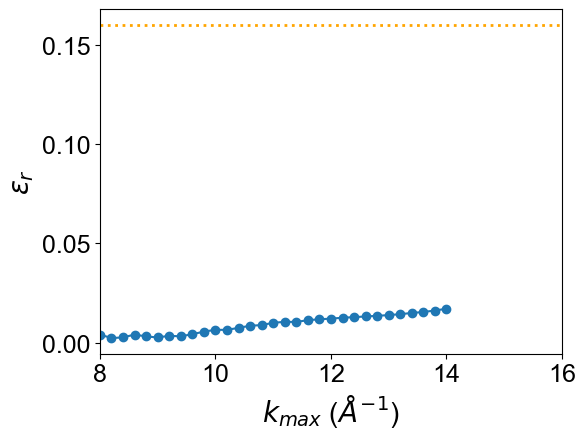

In [ ]:
# Define interactive widgets
data_path_widget = widgets.Text(value="/Users/cheny8/_0SPC/Larch_k_range/test/Cufoil_merge.dat", description='Data Path:', style={'description_width': 'initial'}, layout={'width': '600px'})
noise_factor_widget = widgets.FloatText(value=2, description='Noise Factor:', style={'description_width': 'initial'}, layout={'width': '200px'})
noise_threshold_widget = widgets.FloatText(value=0.16, description='Noise Threshold:', style={'description_width': 'initial'}, layout={'width': '200px'})
kmax_start_widget = widgets.FloatText(value=8, description='kmax Start:', style={'description_width': 'initial'},layout={'width': '200px'})
kmax_end_widget = widgets.FloatText(value=14.1, description='kmax End:', style={'description_width': 'initial'},layout={'width': '200px'})
kmax_step_widget = widgets.FloatText(value=0.2, description='kmax Step:', style={'description_width': 'initial'},layout={'width': '200px'})
r_window_size_widget = widgets.FloatText(value=30, description='r window size :',style={'description_width': 'initial'}, layout={'width': '200px'})


# Define the interactive function
def on_submit_interactive(data_path, noise_factor, noise_threshold, kmax_start, kmax_end, kmax_step, r_window_size):
    clear_output(wait=True)  # This clears previous outputs before running new code
    display(gui_box)
    
    data = load_data(data_path)    
    data_nor_bg(data, figure=False)
    # Check if the entered kmax_end value exceeds the limit
    if kmax_end > np.max(data.k):
        print(f"Error: kmax End should not exceed the maximum value of {np.max(data.k)}")
        return
    generate_kmax_low_noise(data, noise_factor, noise_threshold, kmax_start, kmax_end, kmax_step, r_window_size, figure=True)

# Create interactive widgets container
interactive_widgets = widgets.interactive(on_submit_interactive,
                                          data_path=data_path_widget,
                                          noise_factor=noise_factor_widget,
                                          noise_threshold=noise_threshold_widget,
                                          kmax_start=kmax_start_widget,
                                          kmax_end=kmax_end_widget,
                                          kmax_step=kmax_step_widget,
                                          r_window_size=r_window_size_widget,
                                         )

# Define a title using HTML
title_html = widgets.HTML("<h2 style='color: black;'>kmax with Low Data Noise</h2>")

# Create a VBox to organize the title and interactive widgets vertically
gui_box = widgets.VBox([title_html, interactive_widgets])

# Display the VBox
display(gui_box)

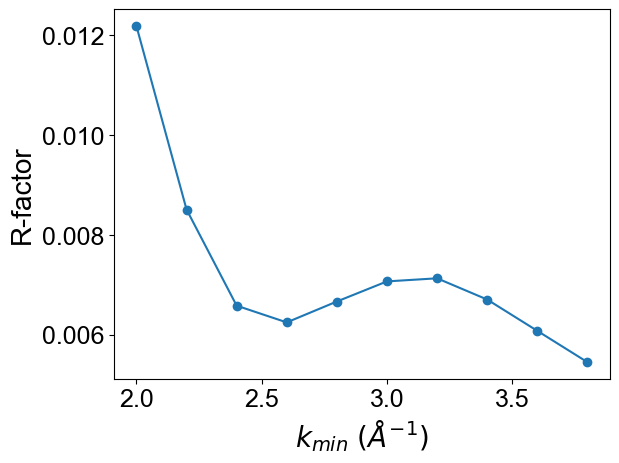

In [84]:
# Define interactive widgets
data_path_widget = widgets.Text(value="/Users/cheny8/_0SPC/Larch_k_range/test/Cufoil_merge.dat", description='Data Path:', style={'description_width': 'initial'}, layout={'width': '600px'})
mineral_name_widget = widgets.Text(value="Copper", description='Mineral Name:', style={'description_width': 'initial'}, layout={'width': '600px'})
element_name_widget = widgets.Text(value="Cu", description='Element:', style={'description_width': 'initial'}, layout={'width': '200px'})
kmax_low_noise_widget = widgets.FloatText(value=14, description='kmax Low Noise:', style={'description_width': 'initial'},layout={'width': '200px'})
kmin_start_widget = widgets.FloatText(value=2, description='kmin Start:', style={'description_width': 'initial'},layout={'width': '200px'})
kmin_end_widget = widgets.FloatText(value=4.0, description='kmin End:', style={'description_width': 'initial'},layout={'width': '200px'})
kmin_step_widget = widgets.FloatText(value=0.2, description='kmin Step:', style={'description_width': 'initial'},layout={'width': '200px'})

# Define the interactive function
def on_submit_interactive(data_path, mineral_name, element_name, kmax_low_noise, kmin_start, kmin_end, kmin_step):
    data = load_data(data_path)    

    data1=copy.deepcopy(data)
    data_nor_bg(data1, figure=False)
    feff_path1_file, reff = generate_feff_path1(cif=mineral_name, element=element_name, structure_num=3, structure_show=False, feff_show=False) 
    de0, k_theory, chi_theory = first_shell_theory(data1, kmax_low_noise, feff_path1_file, reff, figure=False)
    data2=copy.deepcopy(data)
    data_nor_bg_theory(data2, kmax_low_noise, de0, k_theory, chi_theory, reff, figure=False)
   
    # Check if the entered kmin_start value exceeds the limit
    if kmin_start < np.min(data2.k):
        print(f"Error: kmin Start should not exceed the minimum value of {np.min(data.k)}")
        return
    generate_kmin_small_r_factor(data2, kmax_low_noise, feff_path1_file, kmin_start, kmin_end, kmin_step, reff, fit_report=False, figure=True)



# Create interactive widgets container
interactive_widgets = widgets.interactive(on_submit_interactive,
                                          data_path=data_path_widget,
                                          mineral_name=mineral_name_widget,
                                          element_name=element_name_widget,
                                          kmax_low_noise=kmax_low_noise_widget,
                                          kmin_start=kmin_start_widget,
                                          kmin_end=kmin_end_widget,
                                          kmin_step=kmin_step_widget,
                                         )

# Define a title using HTML
title_html = widgets.HTML("<h2 style='color: black;'>kmin with Small R-factor</h2>")

# Create a VBox to organize the title and interactive widgets vertically
gui_box = widgets.VBox([title_html, interactive_widgets])

# Display the VBox
display(gui_box)

## Test